
# Train Logisitic Regression
This notebook trains and exports a LR model on the Waseem and Hovy 2016 dataset.

**Trains on:** SemEval (2019)

In [1]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

# Mount drive for loading the data
drive.mount('/content/drive')

import sys
sys.path.append("drive/MyDrive/Colab Notebooks")

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from google.colab import drive
import preprocessor as p
import html
import pickle
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from reader import Reader
simplefilter("ignore", category=ConvergenceWarning)

Mounted at /content/drive


In [3]:
NUM_FOLDS = 10
MAX_N_GRAM = 4
FILENAME = "drive/MyDrive/Colab Notebooks/data/sem_eval_all.pkl"

In [4]:
def preprocess(data):
    """Preprocesses the data by cleaning URLs and MENTIONS since these do not
    contain any valuable information."""
    p.set_options(p.OPT.URL, p.OPT.MENTION)

    return list(map(lambda text: p.clean(html.unescape(text)), data))

In [5]:
# Mount drive for loading the datasets
drive.mount('/content/drive')
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess and split data

In [6]:
reader = Reader(filename=FILENAME)
X, y = reader.load()
X = preprocess(X)

mapping = {'hate': 1, 'none': 0}
y = [mapping[b] for b in y]

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y, test_size=0.10)

## Tokenize data

In [7]:
vectorizer = CountVectorizer(ngram_range=(1, MAX_N_GRAM), analyzer="char")
X_train_transformed = vectorizer.fit_transform(X_train)

## Fit and export LR model

In [8]:
model = LogisticRegressionCV(cv=10, random_state=0, max_iter=200)
model.fit(X_train_transformed, y_train)

LogisticRegressionCV(cv=10, max_iter=200, random_state=0)

In [9]:
dump(model, '/content/drive/MyDrive/Colab Notebooks/output/logistic-regression-semeval.joblib') 

['/content/drive/MyDrive/Colab Notebooks/output/logistic-regression-sem-eval.joblib']

## Test LR model

In [10]:
X_test_transformed = vectorizer.transform(X_test)
probabilities = model.predict_proba(X_test_transformed)
predictions = np.argmax(probabilities, axis=1)

In [11]:
print(metrics.accuracy_score(y_test, predictions))

0.7341666666666666


LR models are always well-calibrated by default

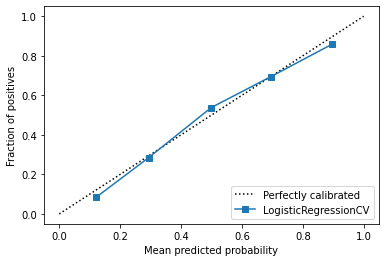

In [12]:
probs = np.max(probabilities, axis=1)
disp = CalibrationDisplay.from_estimator(model, X_test_transformed, y_test)
plt.show()

In [13]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       696
           1       0.71      0.63      0.67       504

    accuracy                           0.73      1200
   macro avg       0.73      0.72      0.72      1200
weighted avg       0.73      0.73      0.73      1200

